# 目的
- 基礎的な集計をする

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime as dt

# データの取得

In [2]:
def get_data(db_file='../data/choco-ball.db', table_name='measurement'):
    """
    dbファイルから計測データを取得する
    
    TODO:
        エラー処理を入れる
    """
    con = sqlite3.connect(db_file)
    sql = 'SELECT '
    sql += 'measure_date,best_before,weight,box_weight,ball_number,factory,shop,angel '
    sql += ', (weight - box_weight), (weight - box_weight)/ball_number '
    sql += 'FROM ' + table_name
    sql += ';'
    sql_result = con.execute(sql)
    res = sql_result.fetchall()
    con.close()
    data = pd.DataFrame(res, columns=['measure_date','best_before','weight','box_weight','ball_number','factory','shop','angel', 'net_weight', 'mean_weight'])
    print 'Shape of MeasurementData(record_num, n_columns) : {}'.format(data.shape)
    return data

def get_date_str():
    tdatetime = dt.now()
    tstr = tdatetime.strftime('%Y-%m-%d')
    return tstr

# 基礎集計

In [3]:
def output_hist(data, plt_file, min_range=27.0, max_range=31.0, step=0.1, spec=28.0):
    b = np.arange(min_range, max_range, step)
    ret = plt.hist(data['net_weight'], 
                   bins=b, color="#0000FF", alpha=0.5, edgecolor="#0000FF", 
                   label='measure', normed=True)
    plt.vlines(x=spec, ymin=0, ymax=ret[0].max(), 
               colors='#FF0000', linewidths=2, label='spec')
    # 最尤推定パラメータの分布
    x = np.linspace(min_range, max_range, 300)
    y = stats.norm.pdf(x, loc=data['net_weight'].mean(), scale=data['net_weight'].std())
    #plt.plot(x, y, lw=3, color='#0000FF', label='MLE')
    plt.legend()
    plt.xlabel('net weight [g]')
    plt.ylabel('frequency')
    plt.savefig(plt_file)
    print 'save_figure : {}'.format(plt_file)

In [4]:
def main():
    db_file = '../data/choco-ball.db'
    table_name = 'measurement'
    # 計測データ取得
    m_data = get_data(db_file=db_file, table_name=table_name)
    # ファイル名のラベルのために日付を取得
    t_str = get_date_str()
    # データ集計
    output_hist(data=m_data, plt_file='fig/base_hist_{}.png'.format(t_str))
    return m_data

Shape of MeasurementData(record_num, n_columns) : (30, 10)
save_figure : fig/base_hist_2017-12-02.png


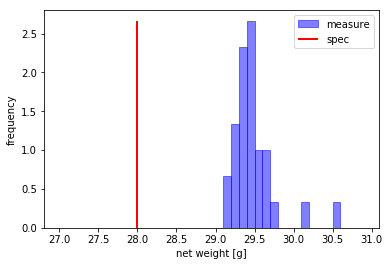

In [5]:
data = main()